# Quick start guide

MDAnalysis version: ≥ 0.18.0

**Last updated:** December 2022 with MDAnalysis 2.4.0

This guide is designed as a basic introduction to MDAnalysis to get you up and running. You can see more complex tasks in our [Example notebooks](https://userguide.mdanalysis.org/stable/examples/README.html). This page outlines how to:

* [load a molecular dynamics structure or trajectory](#Loading-a-structure-or-trajectory)
* [work with AtomGroups, a central data structure in MDAnalysis](#Working-with-groups-of-atoms)
* [work with a trajectory](#Working-with-trajectories)
* [write out coordinates](#Writing-out-coordinates)
* [use the analysis algorithms in MDAnalysis](#Analysis)
* [correct and automated citation of MDAnalysis and algorithms](#References)

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, GRO, XTC

import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

print(mda.Universe(PSF, DCD))
print("Using MDAnalysis version", mda.__version__)

%matplotlib inline

<Universe with 3341 atoms>
Using MDAnalysis version 2.6.0-dev0


This tutorial assumes that you already have MDAnalysis installed. Running the cell above should give something similar to:

```console
<Universe with 3341 atoms>
2.6.0
```
If you get an error message, you need to install MDAnalysis. If your version is under `0.18.0`, you need to upgrade MDAnalysis. [Instructions for both are here.](https://www.mdanalysis.org/UserGuide/installation) After installing, restart this notebook.

## Overview

MDAnalysis is a Python package that provides tools to access and analyse data in molecular dynamics trajectories. Several key data structures form the backbone of MDAnalysis.

* A molecular system consists of particles. A particle is represented as an `Atom` object, even if it is a coarse-grained bead. 
* `Atom`s are grouped into [AtomGroup](https://www.mdanalysis.org/UserGuide/atomgroup)s. The `AtomGroup` is probably the most important class in MDAnalysis, as almost everything can be accessed through it. See [Working with atoms](#Working-with-groups-of-atoms) below. 
* A `Universe` contains all the particles in a molecular system in an `AtomGroup` accessible at the `.atoms` attribute, and combines it with a trajectory at `.trajectory`. 

A fundamental concept in MDAnalysis is that at any one time, 
only one time frame of the trajectory is being accessed. The 
`trajectory` attribute of a `Universe` is usually a file reader. 
Think of the trajectory as a function $X(t)$ of the frame index $t$ 
that only makes the data from this specific frame available. This structure is important 
because it allows MDAnalysis to work with trajectory files too large to fit 
into the computer's memory. 

MDAnalysis stores trajectories using its [internal units](/Users/micaela/UserGuide/doc/source/units.rst): **Å** (**ångström**) for
**length** and **ps** (**picosecond**) for **time**, regardless of the original MD data format.


## Loading a structure or trajectory

Working with MDAnalysis typically starts with loading data into a `Universe`, the central data structure in MDAnalysis. The [user guide](https://www.mdanalysis.org/UserGuide/universe) has a complete explanation of ways to create and manipulate a `Universe`.


The first arguments for creating a `Universe` are topology and trajectory files.

* A **topology file** is always required for loading data into a Universe. A topology file lists atoms, residues, and their connectivity. MDAnalysis accepts the PSF, PDB, CRD, and GRO formats.

* A topology file can then be followed by **any number of trajectory files**. A trajectory file contains a list of coordinates in the order defined in the topology. If no trajectory files are given, then only a structure is loaded. If multiple trajectory files are given, the trajectories are concatenated in the given order. MDAnalysis accepts single frames (e.g. PDB, CRD, GRO) and timeseries data (e.g. DCD, XTC, TRR, XYZ). 

In [2]:
psf = mda.Universe(PSF)
print(psf)
print(hasattr(psf, 'trajectory'))

<Universe with 3341 atoms>
False


As PSF files don't contain any coordinate information and no trajectory file has been loaded, the `psf` universe does not contain a trajectory. If the topology file does contain coordinate information, a trajectory of 1 frame is created.

In [3]:
gro = mda.Universe(GRO)
print(gro)
print(len(gro.trajectory))

<Universe with 47681 atoms>
1


For the remainder of this guide we will work with the universe `u`, created below. This is a simulation where the enzyme adenylate kinase samples a transition from a closed to an open conformation [(Beckstein *et al.*, 2009)](https://doi.org/10.1016/j.jmb.2009.09.009).

In [4]:
u = mda.Universe(PSF, DCD)
print(u)
print(len(u.trajectory))

<Universe with 3341 atoms>
98


<div class="alert alert-info">

**Note**

The MDAnalysis test suite is packaged with a bunch of test files and trajectories, which are named after their file format. We are using these files throughout this guide for convenience. To analyse your own files, simply replace the `PSF` and `DCD` above with paths to your own files. For example:

```python
structure_only = mda.Universe("my_pdb_file.pdb")
```
</div>

## Working with groups of atoms

Most analysis requires creating and working with an `AtomGroup`, a collection of `Atom`s. For convenience, you can also work with chemically meaningful groups of `Atoms` such as a `Residue` or a `Segment`. These come with analogous containers to `AtomGroup`: `ResidueGroup` and `SegmentGroup`. For instance, the `.residues` attribute of a `Universe` returns a `ResidueGroup`.

In [5]:
print(u.residues)

<ResidueGroup [<Residue MET, 1>, <Residue ARG, 2>, <Residue ILE, 3>, ..., <Residue ILE, 212>, <Residue LEU, 213>, <Residue GLY, 214>]>


### Selecting atoms

The easiest way to access the particles of your `Universe` is with the `atoms` attribute:

In [6]:
u.atoms

<AtomGroup with 3341 atoms>

This returns an `AtomGroup`, which can be thought of as a list of `Atom` objects. Most analysis involves working with groups of atoms in `AtomGroup`s. `AtomGroup`s can easily be created by slicing another `AtomGroup`. For example, the below slice returns the last five atoms.

In [7]:
last_five = u.atoms[-5:]
print(last_five)

<AtomGroup [<Atom 3337: HA1 of type 6 of resname GLY, resid 214 and segid 4AKE>, <Atom 3338: HA2 of type 6 of resname GLY, resid 214 and segid 4AKE>, <Atom 3339: C of type 32 of resname GLY, resid 214 and segid 4AKE>, <Atom 3340: OT1 of type 72 of resname GLY, resid 214 and segid 4AKE>, <Atom 3341: OT2 of type 72 of resname GLY, resid 214 and segid 4AKE>]>


MDAnalysis supports fancy indexing: passing an array or list of indices to get a new AtomGroup with the atoms at those indices in the old AtomGroup.

In [8]:
print(last_five[[0, 3, -1, 1, 3, 0]])

<AtomGroup [<Atom 3337: HA1 of type 6 of resname GLY, resid 214 and segid 4AKE>, <Atom 3340: OT1 of type 72 of resname GLY, resid 214 and segid 4AKE>, <Atom 3341: OT2 of type 72 of resname GLY, resid 214 and segid 4AKE>, <Atom 3338: HA2 of type 6 of resname GLY, resid 214 and segid 4AKE>, <Atom 3340: OT1 of type 72 of resname GLY, resid 214 and segid 4AKE>, <Atom 3337: HA1 of type 6 of resname GLY, resid 214 and segid 4AKE>]>


MDAnalysis has also implemented a [powerful atom selection language](https://userguide.mdanalysis.org/stable/selections.html) that is similar to existing languages in [VMD](https://www.ks.uiuc.edu/Research/vmd/), [PyMol](https://pymol.org/2/), and other packages. This is available with the `.select_atoms()` function  of an `AtomGroup` or `Universe` instance:

In [9]:
print(u.select_atoms('resname ASP or resname GLU'))

<AtomGroup [<Atom 318: N of type 54 of resname GLU, resid 22 and segid 4AKE>, <Atom 319: HN of type 1 of resname GLU, resid 22 and segid 4AKE>, <Atom 320: CA of type 22 of resname GLU, resid 22 and segid 4AKE>, ..., <Atom 3271: OE2 of type 72 of resname GLU, resid 210 and segid 4AKE>, <Atom 3272: C of type 20 of resname GLU, resid 210 and segid 4AKE>, <Atom 3273: O of type 70 of resname GLU, resid 210 and segid 4AKE>]>


Numerical ranges can be written as `first-last` or `first:last` where the range is **inclusive**. Note that in slicing, the `last` index is not included.

In [10]:
print(u.select_atoms('resid 50-100').n_residues)
print(u.residues[50:100].n_residues)

51
50


Selections can also be combined with boolean operators, and allow wildcards. 

For example, the command below selects the $C_{\alpha}$ atoms of glutamic acid and histidine in the first 100 residues of the protein. Glutamic acid is typically named "GLU", but histidine can be named "HIS", "HSD", or "HSE" depending on its protonation state and the force field used.

In [11]:
u.select_atoms("(resname GLU or resname HS*) and name CA and (resid 1:100)")

<AtomGroup with 6 atoms>

<div class="alert alert-info">

**Note**

An `AtomGroup` created from a selection is sorted and duplicate elements are removed. This is not true for an `AtomGroup` produced by slicing. Thus, slicing can be used when the order of atoms is crucial.
</div>



The [user guide](https://userguide.mdanalysis.org/stable/atomgroup.html) has a complete rundown of creating `AtomGroup`s through indexing, selection language, and set methods.

### Getting atom information from AtomGroups

An `AtomGroup` can tell you information about the atoms inside it with a number of convenient attributes.

In [12]:
print(u.atoms[:20].names)

['N' 'HT1' 'HT2' 'HT3' 'CA' 'HA' 'CB' 'HB1' 'HB2' 'CG' 'HG1' 'HG2' 'SD'
 'CE' 'HE1' 'HE2' 'HE3' 'C' 'O' 'N']


In [13]:
print(u.atoms[50:70].masses)

[ 1.008  1.008  1.008 12.011  1.008  1.008 12.011  1.008  1.008  1.008
 12.011 15.999 14.007  1.008 12.011  1.008 12.011  1.008 12.011  1.008]


It also knows which residues and segments the atoms belong to. The `.residues` and `.segments` return a `ResidueGroup` and `SegmentGroup`, respectively.

In [14]:
print(u.atoms[:20].residues)
print(u.atoms[-20:].segments)

<ResidueGroup [<Residue MET, 1>, <Residue ARG, 2>]>
<SegmentGroup [<Segment 4AKE>]>


Note that there are no duplicates in the `ResidueGroup` and `SegmentGroup` above. To get residue attributes atom-wise, you can access them directly through `AtomGroup`.

In [15]:
print(u.atoms[:20].resnames)

['MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET'
 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'MET' 'ARG']


You can group atoms together by topology attributes.

For example, to group atoms with the same residue name and atom name together:

In [16]:
near_met = u.select_atoms('not resname MET and (around 2 resname MET)')
sorted(near_met.groupby(['resnames', 'names']))

[('ALA', 'C'),
 ('ALA', 'HN'),
 ('ARG', 'N'),
 ('ASN', 'O'),
 ('ASP', 'C'),
 ('ASP', 'N'),
 ('GLN', 'C'),
 ('GLU', 'N'),
 ('ILE', 'C'),
 ('LEU', 'N'),
 ('LYS', 'N'),
 ('THR', 'N')]

A complete list of topology attributes can be found [in the user guide.](https://userguide.mdanalysis.org/stable/topology_system.html)

### AtomGroup positions and methods

The `.positions` attribute is probably the most important information you can get from an `AtomGroup`: a `numpy.ndarray` of coordinates, with the shape `(n_atoms, 3)`.

In [17]:
ca = u.select_atoms('resid 1-5 and name CA')
print(ca.positions)
print(ca.positions.shape)

[[11.664622    8.393473   -8.983231  ]
 [11.414839    5.4344215  -6.5134845 ]
 [ 8.959755    5.612923   -3.6132305 ]
 [ 8.290068    3.075991   -0.79665166]
 [ 5.011126    3.7638984   1.130355  ]]
(5, 3)


A number of other quantities have been defined for an AtomGroup, including:

* `.center_of_mass()`
* `.center_of_geometry()`
* `.total_mass()`
* `.total_charge()`
* `.radius_of_gyration()`
* `.bsphere()` (the bounding sphere of the selection)

See the [user guide](https://userguide.mdanalysis.org/stable/topology_system.html) for a complete list and description of AtomGroup methods.

In [18]:
print(ca.center_of_mass())

[ 9.06808195  5.25614133 -3.75524844]


<div class="alert alert-info">

**Note**

The `.center_of_mass()` function, like many of the analysis modules in MDAnalysis, relies on having accurate mass properties available. **[Particle masses may not always be available or accurate!](https://userguide.mdanalysis.org/stable/formats/guessing.html#masses)**

Currently, MDAnalysis assigns masses to particles based on their element or 'atom type', which is guessed from the particle name. If MDAnalysis guesses incorrectly (e.g. a calcium atom called CA is treated as a $C_{\alpha}$), the mass of that atom will be inaccurate. If MDAnalysis has no idea what the particle is (e.g. coarse-grained beads), it will raise a warning, and give that particle a mass of 0. 

To be certain that MDAnalysis is using the correct masses, you can set them manually.
</div>

MDAnalysis can also create [topology geometries](https://userguide.mdanalysis.org/stable/topology_system.html#topology-objects) such as bonds, angles, dihedral angles, and improper angles from an `AtomGroup`. This `AtomGroup` has a special requirement: only the atoms involved in the geometry can be in the group. For example, an `AtomGroup` used to create a bond can only have 2 atoms in it; an `AtomGroup` used to create a dihedral or improper angle must have 4 atoms.

In [19]:
nhh = u.atoms[:3]
print(nhh.names)

['N' 'HT1' 'HT2']


After a topology object such as an angle is created, the value of the angle (in degrees) can be calculated based on the positions of the atoms.

In [20]:
angle_nhh = nhh.angle
print(f"N-H-H angle: {angle_nhh.value():.2f}")

N-H-H angle: 37.99


Note that the order of the atoms matters for angles, dihedrals, and impropers. The value returned for an angle is the angle between first and third atom, with the apex at the second. Fancy indexing is one way to get an ordered AtomGroup.
```
   3
  /
 /
2------1
```

In [21]:
hnh = u.atoms[[1, 0, 2]]
print(hnh.names)

['HT1' 'N' 'HT2']


In [22]:
angle_hnh = hnh.angle
print(f"N-H-H angle: {angle_hnh.value():.2f}")

N-H-H angle: 106.20


## Working with trajectories

The [trajectory of a Universe contains the changing coordinate information](https://userguide.mdanalysis.org/stable/trajectories/trajectories.html). The number of frames in a trajectory is its length:

In [23]:
print(len(u.trajectory))

98


The standard way to assess the information of each frame in a trajectory is to iterate over it. When the timestep changes, the universe only contains information associated with that timestep.

In [24]:
for ts in u.trajectory[:20]:
    time = u.trajectory.time
    rgyr = u.atoms.radius_of_gyration()
    print(f"Frame: {ts.frame:3d}, Time: {time:4.0f} ps, Rgyr: {rgyr:.4f} A")

Frame:   0, Time:    1 ps, Rgyr: 16.6690 A
Frame:   1, Time:    2 ps, Rgyr: 16.6732 A
Frame:   2, Time:    3 ps, Rgyr: 16.7315 A
Frame:   3, Time:    4 ps, Rgyr: 16.7223 A
Frame:   4, Time:    5 ps, Rgyr: 16.7440 A
Frame:   5, Time:    6 ps, Rgyr: 16.7185 A
Frame:   6, Time:    7 ps, Rgyr: 16.7741 A
Frame:   7, Time:    8 ps, Rgyr: 16.7764 A
Frame:   8, Time:    9 ps, Rgyr: 16.7894 A
Frame:   9, Time:   10 ps, Rgyr: 16.8289 A
Frame:  10, Time:   11 ps, Rgyr: 16.8521 A
Frame:  11, Time:   12 ps, Rgyr: 16.8549 A
Frame:  12, Time:   13 ps, Rgyr: 16.8723 A
Frame:  13, Time:   14 ps, Rgyr: 16.9108 A
Frame:  14, Time:   15 ps, Rgyr: 16.9494 A
Frame:  15, Time:   16 ps, Rgyr: 16.9810 A
Frame:  16, Time:   17 ps, Rgyr: 17.0033 A
Frame:  17, Time:   18 ps, Rgyr: 17.0196 A
Frame:  18, Time:   19 ps, Rgyr: 17.0784 A
Frame:  19, Time:   20 ps, Rgyr: 17.1265 A


After iteration, the trajectory 'resets' back to the first frame. Please see [the user guide](https://userguide.mdanalysis.org/stable/trajectories/trajectories.html) for more information.

In [25]:
print(u.trajectory.frame)

0


You can set the timestep of the trajectory with the frame index:

In [26]:
print(u.trajectory[10].frame)

10


This persists until the timestep is next changed.

In [27]:
frame = u.trajectory.frame
time = u.trajectory.time
rgyr = u.atoms.radius_of_gyration()
print("Frame: {:3d}, Time: {:4.0f} ps, Rgyr: {:.4f} A".format(frame, time, rgyr))

Frame:  10, Time:   11 ps, Rgyr: 16.8521 A


Generally, trajectory analysis first collects frame-wise data in a list.

In [28]:
rgyr = []
time = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())

This can then be converted into other data structures, such as a numpy array or a pandas DataFrame. It can be plotted (as below), or used for further analysis. 

The following section requires the [pandas](https://pandas.pydata.org) package (installation: `conda install pandas` or `pip install pandas`) and [matplotlib](https://matplotlib.org/) (installation: `conda install matplotlib` or `pip install matplotlib`)

In [29]:
import pandas as pd
rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'

rgyr_df.head()

,Radius of gyration (A)
Time (ps),
1.0,16.669018
2.0,16.673217
3.0,16.731454
4.0,16.722283
5.0,16.743961


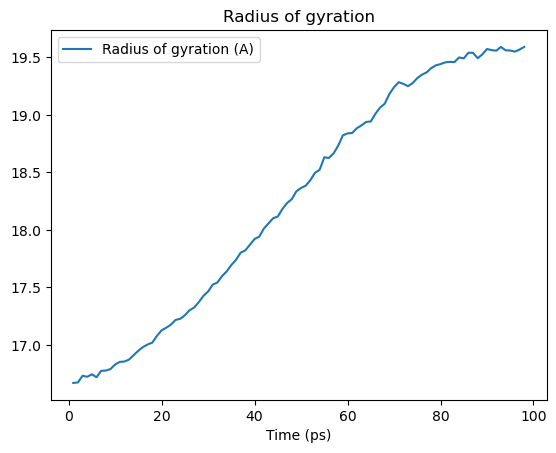

In [30]:
rgyr_df.plot(title='Radius of gyration')
plt.show()

### Dynamic selection

As seen above, coordinates change while iterating over the trajectory. Therefore, properties calculated from the coordinates, such as the radius of gyration, also change. 

Selections are often defined on static properties that do not change when moving through a trajectory. Above, the static selection is all the atoms that are in a protein. You can define the selection once and then recalculate the property of interest for each frame of the trajectory.

However, some selections contain distance-dependent queries (such as `around` or `point`, [see selection keywords for more details](https://userguide.mdanalysis.org/stable/selections.html)). In this case, the selection should be updated for each time step using a dynamic selection by setting the keyword `updating=True`. This command gives an `UpdatingAtomGroup` rather than a static `AtomGroup`.



In [31]:
dynamic = u.select_atoms('around 2 resname ALA', updating=True)
print(type(dynamic))
dynamic

<class 'MDAnalysis.core.groups.UpdatingAtomGroup'>


<AtomGroup with 54 atoms, with selection 'around 2 resname ALA' on the entire Universe.>

In [32]:
static = u.select_atoms('around 2 resname ALA')
print(type(static))
static

<class 'MDAnalysis.core.groups.AtomGroup'>


<AtomGroup with 54 atoms>

When you call the next frame of the universe, the atoms in the dynamic selection are updated, whereas the atoms in the static selection remain the same.

In [33]:
u.trajectory.next()
dynamic

<AtomGroup with 56 atoms, with selection 'around 2 resname ALA' on the entire Universe.>

In [34]:
static

<AtomGroup with 54 atoms>

## Writing out coordinates

MDAnalysis supports [writing data out](https://userguide.mdanalysis.org/stable/selections.html) into a range of file formats, including both single frame formats (e.g. PDB, GRO) and trajectory writers (e.g. XTC, DCD, and multi-frame PDB files). (You can [also write selections out to other programs, such as VMD macros.](https://userguide.mdanalysis.org/stable/formats/selection_exporters.html))The user guide has a [complete list of formats](https://userguide.mdanalysis.org/stable/formats/index.html), each with their own [reference pages](https://userguide.mdanalysis.org/stable/formats/format_reference.html).

### Single frame

The most straightforward way to write to a file that can only hold a single frame is to use the `write()` method of any `AtomGroup`. MDAnalysis uses the file extension to determine the output file format. For instance, to only write out the $C_{\alpha}$ atoms to a file in GRO format:

```python
ca = u.select_atoms('name CA')
ca.write('calphas.gro')
```

### Trajectories

The [standard way to write out trajectories](https://userguide.mdanalysis.org/stable/reading_and_writing.html#output) is to:

1. Open a trajectory `Writer` and specify how many atoms a frame will contain
2. Iterate through the trajectory and write coordinates frame-by-frame with `Writer.write()`
3. If you do not use the context manager and the `with` statement below, you then need to close the trajectory with `.close()`.

For instance, to write out the $C_{\alpha}$ atoms to a trajectory in the XTC format:

```python
ca = u.select_atoms('name CA')
with mda.Writer('calphas.xtc', ca.n_atoms) as w:
    for ts in u.trajectory:
        w.write(ca)
```

## Analysis

MDAnalysis comes with a [diverse set of analysis modules](https://docs.mdanalysis.org/stable/documentation_pages/analysis_modules.html), and the building blocks to [implement your own](https://userguide.mdanalysis.org/stable/examples/analysis/custom_trajectory_analysis.html). (Please see a list of analysis tutorials in the [user guide](https://userguide.mdanalysis.org/stable/examples/analysis/README.html).)

The majority of these follow a common interface:

1. Initialise the analysis with a `Universe` and other required parameters.
2. Run the analysis with `.run()`. Optional arguments are the `start` frame index, `stop` frame index, `step` size, and toggling `verbose`. The default is to run analysis on the whole trajectory.
3. Results are stored within the class.
4. Often, a function is available to operate on single frames.

**However, not all analysis uses this model. It is important to check the documentation for each analysis.** You can also see examples in the [Example gallery](https://userguide.mdanalysis.org/stable/examples/README.html).

Below, simple RMSD analysis is shown. The `rms` module follows the interface above.

### RMSD

Not all sub-modules of MDAnalysis are imported with `import MDAnalysis`. Most analysis modules have to be imported explicitly. 

In [35]:
from MDAnalysis.analysis import rms

MDAnalysis provides a `rmsd()` function for calculating the RMSD between two numpy arrays of coordinates.

In [36]:
bb = u.select_atoms('backbone')

u.trajectory[0] # first frame
first = bb.positions

u.trajectory[-1] #last frame
last = bb.positions

rms.rmsd(first, last)

6.852774844656239

An `RMSD` class is also provided to operate on trajectories. 

Below, the `RMSD` class is created. 

* The first argument is the `AtomGroup` or `Universe` for which the RMSD is calculated. 
* As a reference `AtomGroup` or `Universe` is not given as the second argument, the default is to align to the current frame of the first argument. Here it is set to the first frame. 
* We choose to align the trajectory over the backbone atoms, and then compute the RMSD for the backbone atoms (`select`). 
* Then, without re-aligning the trajectory, the RMSD is also computed (`groupselections`) for the $C_{\alpha}$ atoms (`name CA`) and every protein atom (`protein`).

The RMSD is computed when we call `.run()`.

In [37]:
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()

The results are stored in the `results.rmsd` attribute. This is an array with the shape `(n_frames, 2 + n_selections)`.

In [38]:
print(rmsd_analysis.results.rmsd.shape)

(98, 5)


We can interpret this as an array with 98 rows and 5 columns. Each row is the RMSD associated with a frame in the trajectory. The columns are as follows:

1. Frame number
2. Time (ps)
3. RMSD (backbone)
4. RMSD (C-alpha)
5. RMSD (protein)

We can turn this into a `pandas` DataFrame and plot the results.

In [39]:
import pandas as pd

rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()

,Backbone,C-alphas,Protein
Time (ps),,,
1.0,5.834344e-07,4.263638e-08,5.443850e-08
2.0,4.636592e-01,4.235205e-01,6.934167e-01
3.0,6.419340e-01,5.939111e-01,8.748416e-01
4.0,7.743983e-01,7.371346e-01,1.052780e+00
5.0,8.588600e-01,8.279498e-01,1.154986e+00


<Axes: title={'center': 'RMSD'}, xlabel='Time (ps)'>

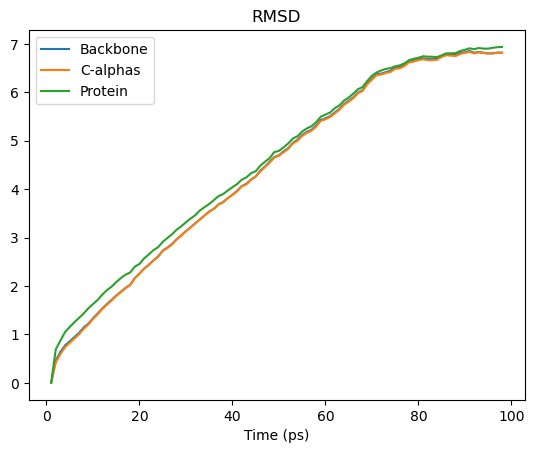

In [40]:
rmsd_df.plot(title='RMSD')

See the [the RMSD and alignment notebooks](https://userguide.mdanalysis.org/stable/examples/analysis/README.html#alignments-and-rms-fitting) for more information.

## References

When using MDAnalysis in published work, please cite both these papers:

* N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. MDAnalysis: A Toolkit for the Analysis of Molecular Dynamics Simulations. *J. Comput. Chem.* **32** (2011), 2319–2327. doi:[10.1002/jcc.21787](http://dx.doi.org/10.1002/jcc.21787)

* R. J. Gowers, M. Linke, J. Barnoud, T. J. E. Reddy, M. N.
   Melo, S. L. Seyler, D. L. Dotson, J. Domanski, S. Buchoux, I. M. Kenney,
   and O. Beckstein. [MDAnalysis: A Python package for the rapid analysis of
   molecular dynamics simulations](http://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html). In S. Benthall and S. Rostrup, editors,
   *Proceedings of the 15th Python in Science Conference*, pages 98-105,
   Austin, TX, 2016. SciPy. doi:[10.25080/Majora-629e541a-00e](https://doi.org/10.25080/Majora-629e541a-00e)
   
MDAnalysis includes many algorithms and modules that should also be individually cited. For example, if you use the `MDAnalysis.analysis.rms` or `MDAnalysis.analysis.align` modules, please cite:

* Douglas L. Theobald. Rapid calculation of RMSD using a
   quaternion-based characteristic polynomial. *Acta Crystallographica A*
   **61** (2005), 478-480.
* Pu Liu, Dmitris K. Agrafiotis, and Douglas L. Theobald. Fast
   determination of the optimal rotational matrix for macromolecular
   superpositions. *J. Comput. Chem.* **31** (2010), 1561–1563.
   
The primary sources of each module will be in their documentation.

### Automatic citations with duecredit

Citations can be also be automatically generated using `duecredit`. [Complete installation and usage instructions can be found in the user guide](https://mdanalysis.org/UserGuide/references.html), but it is simple to generate a list of citations for your python script `my_script.py`.

```console
$ python -m duecredit my_script.py
```

This extracts citations into a hidden file, which can then be exported to different formats. For example, to display them as BibTeX, use the command:

```console
$ duecredit summary --format=bibtex
```